In [ ]:
!nvidia-smi

Tue May  4 11:22:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    32W / 250W |    923MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.0961803days (8309.98sec)


In [ ]:
!git clone https://github.com/yours-schnee/custom_ImageNet.git

fatal: destination path 'custom_ImageNet' already exists and is not an empty directory.


In [ ]:
!pip install -e ./custom_ImageNet

ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /content/custom_ImageNet


In [ ]:
import sys
sys.path.append('/content/custom_ImageNet')

In [ ]:
import custom_ImageNet
from utils.ImageNetDataset import make_path_list
from utils.ImageNetDataset import str_convert
from utils.ImageNetDataset import ImageNetDataset

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [ ]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data
import datetime

!pip install tensorboardX
import tensorboardX as tbx
from tensorboardX import SummaryWriter


     |████████████████████████████████| 122kB 10.0MB/s 


In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "drive/My Drive/ImageNet/retina_30random_ImagenetTrain.zip" /content/
!cp "drive/My Drive/ImageNet/retina_original_ImagenetTest.zip" /content/

In [ ]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
!7z x retina_30random_ImagenetTrain.zip
!mv "content/retina_ImagenetTrain" ../content/
!7z x retina_original_ImagenetTest.zip
!mv "content/retina_ImagenetTest" ../content/

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import shutil

directory = 'content'

try:
    shutil.rmtree(directory)
except FileNotFoundError:
    pass

In [ ]:
def make_path_list_png(rootpath):
    """
    To create the list of file path about Image data and annotation data
    for training and test

    Inputs
    --------------------
    rootpath : str
        path data for data folder

    Returns
    --------------------
    *_img_list, *_anno_list
        list of path for each data
    """

    img_list = glob.glob(rootpath+'*/*.png')

    return img_list

In [ ]:
rootpathTrain ='retina_ImagenetTrain/'
rootpathTest ='retina_ImagenetTest/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list(rootpathTest)

In [ ]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
classes_list = train_dataset.get_label_relation()

batch_size = 32

In [ ]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [ ]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [ ]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

In [ ]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

In [ ]:
index = 2
imges, label = train_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [ ]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [ ]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [ ]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

### CONST data

In [ ]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 10
else:
    NUM_EPOCS = 30

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

### Network model

In [ ]:
# Load pre-trained VGG-16
use_pretrained = True
net = models.mobilenet_v2(pretrained=use_pretrained)

# Replacement last layer output for 20 classes
net.classifier[1] = nn.Linear(in_features=1280, out_features=N_CLASSES)

net.cuda()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

### Loss function

In [ ]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### Optimization method

In [ ]:
# Optimization setting
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

### Training & Test for model

In [ ]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):
    
    log_path = F"/content/drive/My Drive/Colab Notebooks/Log/"
    now = datetime.datetime.now()
    folder = F"{name}"+now.strftime('%Y%m%d_%H%M%S')

    writer = tbx.SummaryWriter(log_path+folder)

    global best_accuracy;
    global training_losses; global val_losses;
    global train_accuracies; global val_accuracies;
    global epochs;
    global stats; global parent_folder;
    train_loss=0; val_loss=0; train_acc=0; val_acc=0; 
    for epoch in range(epochs,num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_acc = 0       # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        #if(LOAD_STATE==True)and(epoch==epochs+1):
                        #    optimizer.load_state_dict( checkpoint["optimizer_state_dict"] )
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_acc += preds.eq(labels.view_as(preds)).sum().item()

            #print(epoch_acc)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_acc / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_loss=epoch_loss; train_acc=epoch_acc;
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_loss=epoch_loss; val_acc=epoch_acc;

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)
                    
                    total_name = name+".tar"
                    path = F"/content/drive/My Drive/Colab Notebooks/{parent_folder}/{folder_name}/{total_name}"
                    torch.save({"best_model":model.state_dict(),
                                "best_acc":best_accuracy
                                },path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if (epoch%3==0)or(epoch%10==0):
            # Colab's disconnection timing while saving data might cause the broken save data against our hope.
            # So, results every epochs will be saved every epochs.
            
            total_name = name+"_epoch"+str(epoch)+".tar"

            path = F"/content/drive/My Drive/Colab Notebooks/{parent_folder}/{folder_name}/{total_name}"
            torch.save({
                "epoch":epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss":training_losses,
                "val_loss":val_losses,
                "train_acc":train_accuracies,
                "val_acc":val_accuracies
                }, path)
            
        print('-------------')
        writer.add_scalars('/loss', {'train_loss': train_loss,
                                     'val_loss': val_loss
                                    }, epoch)
      
        writer.add_scalars('/acc', {'train_acc': train_acc,
                                    'val_acc': val_acc
                                    }, epoch)

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

In [ ]:
LOAD_STATE = False
EPOCH = 40             # This values need to check the latest tar ffile name with epoch.
parent_folder = "Retina_image"
folder_name = "mobilenet"
name = "07_mobilenet"

if LOAD_STATE:
    stats=[];
    PATH1 =  F"/content/drive/My Drive/Colab Notebooks/{parent_folder}/{folder_name}/{name}.tar"

    checkpoint = torch.load(PATH1)
    best_model = net
    best_model.load_state_dict( checkpoint["best_model"] )
    best_accuracy = 0#checkpoint["best_acc"]

    # Colab's disconnection timing while saving data might cause the broken save data against our hope.
    # So, results every epochs will be saved every epochs.
    total_name = name+"_epoch"+str(EPOCH)+".tar"
    PATH2 =  F"/content/drive/My Drive/Colab Notebooks/{parent_folder}/{folder_name}/{total_name}"

    checkpoint = torch.load(PATH2)
    epochs = checkpoint["epoch"]
    net.load_state_dict( checkpoint["model_state_dict"] )
    optimizer.load_state_dict( checkpoint["optimizer_state_dict"] )
    training_losses = checkpoint["train_loss"]; val_losses = checkpoint["val_loss"];
    train_accuracies = checkpoint["train_acc"]; val_accuracies = checkpoint["val_acc"];
    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

else:
    # start point
    best_model=net;
    best_accuracy = 0;
    training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    stats=[];
    epochs=0;


In [48]:
best_model, stats = train_model(net, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, "mobilenet", DEBUG)

Epoch 1/30
-------------



train Loss: 0.0265 Acc: 73.2011



val Loss: 0.0185 Acc: 81.1831
-------------
Epoch 2/30
-------------



train Loss: 0.0159 Acc: 83.6644



val Loss: 0.0128 Acc: 86.8614
-------------
Epoch 3/30
-------------



train Loss: 0.0118 Acc: 87.8499



val Loss: 0.0096 Acc: 90.1164
-------------
Epoch 4/30
-------------



train Loss: 0.0091 Acc: 90.5803



val Loss: 0.0076 Acc: 92.1206
-------------
Epoch 5/30
-------------



train Loss: 0.0072 Acc: 92.4658



val Loss: 0.0064 Acc: 93.4966
-------------
Epoch 6/30
-------------



train Loss: 0.0058 Acc: 93.9063



val Loss: 0.0057 Acc: 94.1409
-------------
Epoch 7/30
-------------



train Loss: 0.0048 Acc: 94.9129



val Loss: 0.0046 Acc: 95.2626
-------------
Epoch 8/30
-------------



train Loss: 0.0042 Acc: 95.5077



val Loss: 0.0042 Acc: 95.7100
-------------
Epoch 9/30
-------------



train Loss: 0.0035 Acc: 96.2871



val Loss: 0.0037 Acc: 96.2609
-------------
Epoch 10/30
-------------



train Loss: 0.0030 Acc: 96.7966



val Loss: 0.0036 Acc: 96.3852
-------------
Epoch 11/30
-------------



train Loss: 0.0026 Acc: 97.2418



val Loss: 0.0031 Acc: 96.8816
-------------
Epoch 12/30
-------------



train Loss: 0.0023 Acc: 97.4858



val Loss: 0.0028 Acc: 97.2404
-------------
Epoch 13/30
-------------



train Loss: 0.0021 Acc: 97.8211



val Loss: 0.0026 Acc: 97.3892
-------------
Epoch 14/30
-------------



train Loss: 0.0020 Acc: 97.8886



val Loss: 0.0026 Acc: 97.4420
-------------
Epoch 15/30
-------------



train Loss: 0.0017 Acc: 98.2006



val Loss: 0.0024 Acc: 97.6482
-------------
Epoch 16/30
-------------



train Loss: 0.0015 Acc: 98.3921



val Loss: 0.0024 Acc: 97.6906
-------------
Epoch 17/30
-------------



train Loss: 0.0014 Acc: 98.5451



val Loss: 0.0021 Acc: 97.9562
-------------
Epoch 18/30
-------------



train Loss: 0.0013 Acc: 98.6496



val Loss: 0.0023 Acc: 97.7179
-------------
Epoch 19/30
-------------



train Loss: 0.0012 Acc: 98.7344



val Loss: 0.0020 Acc: 98.0749
-------------
Epoch 20/30
-------------



train Loss: 0.0011 Acc: 98.8585



val Loss: 0.0020 Acc: 98.0627
-------------
Epoch 21/30
-------------



train Loss: 0.0010 Acc: 98.9327



val Loss: 0.0019 Acc: 98.2152
-------------
Epoch 22/30
-------------



train Loss: 0.0009 Acc: 98.9981



val Loss: 0.0018 Acc: 98.2209
-------------
Epoch 23/30
-------------



train Loss: 0.0009 Acc: 99.0998



val Loss: 0.0018 Acc: 98.3264
-------------
Epoch 24/30
-------------



train Loss: 0.0008 Acc: 99.1062



val Loss: 0.0018 Acc: 98.3546
-------------
Epoch 25/30
-------------



train Loss: 0.0008 Acc: 99.1594



val Loss: 0.0017 Acc: 98.4441
-------------
Epoch 26/30
-------------



train Loss: 0.0007 Acc: 99.2065



val Loss: 0.0019 Acc: 98.2708
-------------
Epoch 27/30
-------------



train Loss: 0.0007 Acc: 99.2529



val Loss: 0.0018 Acc: 98.2981
-------------
Epoch 28/30
-------------



train Loss: 0.0007 Acc: 99.3026



val Loss: 0.0017 Acc: 98.3857
-------------
Epoch 29/30
-------------



train Loss: 0.0006 Acc: 99.3146



val Loss: 0.0017 Acc: 98.4987
-------------
Epoch 30/30
-------------



train Loss: 0.0006 Acc: 99.3629



val Loss: 0.0015 Acc: 98.5854
-------------
Lowest training loss 0.000594038743278691
Lowest validation loss 0.0015258064514506865
Highest training accuracy 99.36285036166366
Highest validation accuracy 98.58536769138036
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/07_mobilenet_Loss _.png07_mobilenet_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/07_mobilenet_Accuracy _.png07_mobilenet_Accuracy _.png


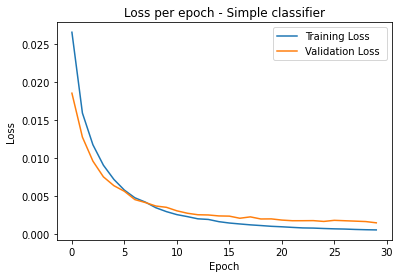

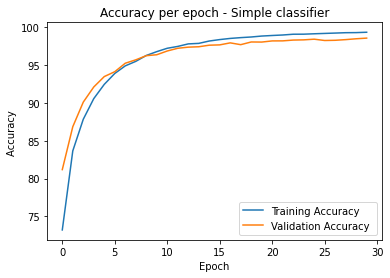

In [49]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 1.4497 
Testing Accuracy: 1556/2000 (77.80%)
apple Class Accuracy: 64/100 (64.00%)
banana Class Accuracy: 80/100 (80.00%)
bear Class Accuracy: 88/100 (88.00%)
bell_pepper Class Accuracy: 72/100 (72.00%)
bird Class Accuracy: 77/100 (77.00%)
broccoli Class Accuracy: 83/100 (83.00%)
cat Class Accuracy: 64/100 (64.00%)
cauliflower Class Accuracy: 70/100 (70.00%)
cow Class Accuracy: 89/100 (89.00%)
dog Class Accuracy: 64/100 (64.00%)
elephant Class Accuracy: 95/100 (95.00%)
fox Class Accuracy: 85/100 (85.00%)
goat Class Accuracy: 61/100 (61.00%)
horse Class Accuracy: 71/100 (71.00%)
mashed_potato Class Accuracy: 82/100 (82.00%)
orange Class Accuracy: 77/100 (77.00%)
pineapple Class Accuracy: 80/100 (80.00%)
pomegranate Class Accuracy: 84/100 (84.00%)
tomato Class Accuracy: 79/100 (79.00%)
zebra Class Accuracy: 91/100 (91.00%)
Classifier has Acc=0.778 P=0.778 R=0.786 F1=0.778
               precision    recall  f1-score   support

        apple       0.82      0.64      0.72     

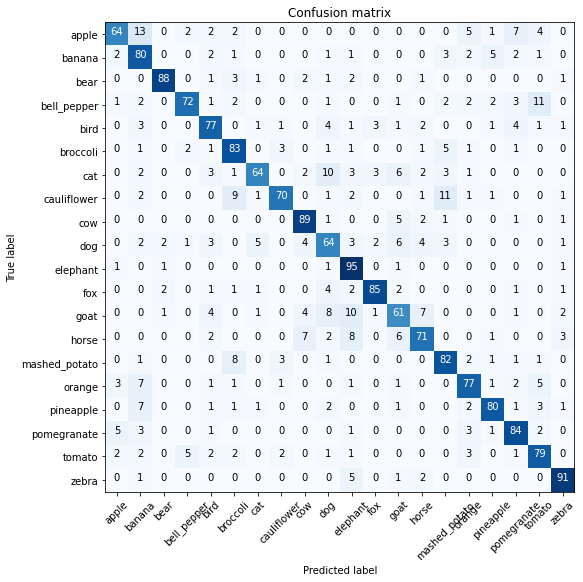

In [50]:
result = test_model(best_model, criterion, name)